# OU REVISITED
In this notebook I wil once again use the OU model as a framework for a statistical arbitrage model, however this time i will generate the weights using a feedforward neural network instead of a static rule based system as before, also allowing me to incorporate transaction costs in the training of the strategy

### 0) Imports and other preparations

In [59]:
LOOKBACK_PERIOD = 100 #2 days is the total lookback period 

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import torch
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

In [57]:
pct_ret = pd.read_csv('pct_returns.csv').set_index('close_time')
pct_ret = pct_ret.loc[:,pct_ret.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

In [58]:
pct_ret

,APEUSDT,RUNEUSDT,JASMYUSDT,FORTHUSDT,NEARUSDT,AAVEUSDT,DOTUSDT,DOGEUSDT,ROSEUSDT,FILUSDT,...,XECUSDT,REIUSDT,ONEUSDT,ADAUSDT,KNCUSDT,XRPUSDT,RADUSDT,XLMUSDT,AXSUSDT,MATICUSDT
close_time,,,,,,,,,,,,,,,,,,,,,
2021-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-12,NaN,0.004066,NaN,NaN,0.101748,-0.023839,-0.036029,-0.010719,0.079330,-0.025340,...,NaN,NaN,-0.018448,-0.035258,0.053857,-0.030474,NaN,-0.024171,0.133099,0.455245
2021-03-13,NaN,-0.079104,NaN,NaN,0.172460,-0.083575,-0.048362,-0.004125,0.144860,0.060738,...,NaN,NaN,0.443614,-0.064155,-0.005064,-0.031365,NaN,-0.043020,0.091685,-0.058097
2021-03-14,NaN,0.027273,NaN,NaN,0.052464,0.109966,0.060351,0.045896,0.058268,0.105610,...,NaN,NaN,-0.103655,0.051769,0.069412,0.047316,NaN,0.046321,0.072892,0.042738
2021-03-15,NaN,-0.074322,NaN,NaN,-0.087262,-0.053512,-0.007805,0.018428,0.220498,0.148165,...,NaN,NaN,0.516387,-0.018583,-0.038511,-0.028433,NaN,-0.020816,0.136605,-0.060665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-28,-0.056182,-0.042268,-0.012555,0.016913,-0.046752,-0.066667,-0.018258,-0.039768,-0.024896,-0.013722,...,-0.022496,-0.048851,-0.025428,-0.000901,0.023536,-0.024825,-0.063103,-0.010387,0.004402,0.009514
2022-08-29,0.029230,-0.007269,0.017264,0.010395,0.001033,0.001232,0.007153,0.014495,0.024901,0.001739,...,0.342466,-0.018127,-0.006021,-0.007212,-0.052720,0.001497,-0.006080,0.003817,0.002922,0.021488
2022-08-30,0.017413,0.018305,0.016627,0.012346,0.029397,0.043050,0.028409,-0.004082,0.009534,0.038194,...,-0.002449,0.003077,0.038869,0.016799,0.004737,-0.006878,-0.001882,-0.000951,-0.002913,0.001353


### 1) Generating the residual portfolios

This is currently done using a pca method as described in Avalanda and Lee (2008), however in the future newer techniques could be used like the one decribed in this paper: Two Machine Learning Approaches for Statistical Arbitrage Pairs Selection. based upon: Deep Clustering with Convolutional Autoencoders, by Xifeng Guo et al. 

In [60]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=30, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in range(res_cov_window_size+1,len(returns)):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_OoS           = returns[(t - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)   
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [61]:
test                      = pct_ret
PCA, pca_portfolio        = pca(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [62]:
residuals

,APEUSDT,RUNEUSDT,JASMYUSDT,FORTHUSDT,NEARUSDT,AAVEUSDT,DOTUSDT,DOGEUSDT,ROSEUSDT,FILUSDT,...,XECUSDT,REIUSDT,ONEUSDT,ADAUSDT,KNCUSDT,XRPUSDT,RADUSDT,XLMUSDT,AXSUSDT,MATICUSDT
close_time,,,,,,,,,,,,,,,,,,,,,
2021-03-11,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-12,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-13,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-14,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-15,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-28,0.0,0.004959,0.002436,-0.021040,0.041536,0.010093,0.012726,-0.011389,0.015764,0.012199,...,0.009726,0.0,-0.000312,-0.002384,0.008056,0.017361,-0.030563,0.008828,-0.000655,0.027648
2022-08-29,0.0,-0.000751,0.016038,0.018474,-0.002885,-0.019976,0.015791,-0.017986,-0.017594,0.029655,...,0.011070,0.0,0.010371,0.027599,0.047962,-0.005295,-0.057585,0.011890,0.034243,0.036075
2022-08-30,0.0,-0.013888,0.011579,-0.038202,-0.005228,-0.006199,-0.001061,0.015587,-0.023494,-0.056218,...,0.274447,0.0,-0.004998,-0.009488,-0.063855,-0.002540,-0.010865,0.002813,-0.009155,0.012584


### 2) Preprocessing the OU signals

In [63]:
def preprocess_ou(data:np.array, lookback:int=30):
    print("Start OU preprocess")
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected before & mask: {np.sum(idxs_selected[t-lookback,:])}")
        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected after & mask: {np.sum(idxs_selected[t-lookback,:])}")
    idxs_selected = torch.as_tensor(idxs_selected)
    print("Finish OU preprocess")
    return windows, idxs_selected

In [64]:
windows, idxs_selected = preprocess_ou(PCA, 30)
windows.shape #AXIS 0: time t, AXIS 1: asset, AXIS 2: signal value, mu, sigma, R2

Start OU preprocess
Finish OU preprocess


(510, 79, 4)

(-2.0, 2.0)

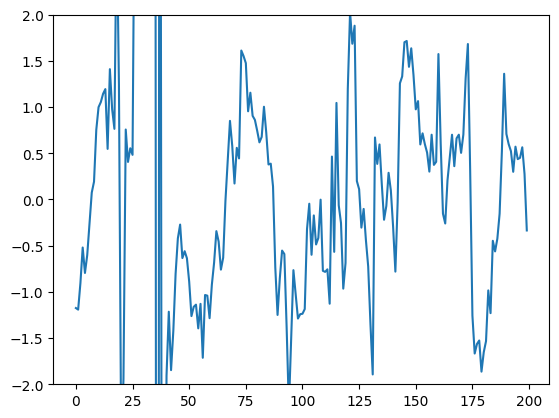

In [65]:
# following plot shows the generated signal for RUNEUSDT
# judging by this plot it looks pretty solid
plt.plot(((windows[-200:,1,0] - windows[-200:,1,1]) / windows[-200:,1,2]))
plt.ylim([-2,2])

### 3) Weight allocation model 

In [98]:
class OUFFN(nn.Module):
    def __init__(self, 
                 logdir,
                 lookback = 30,
                 random_seed=100, 
                 device = "cpu",
                 hidden_units = [4,4,4,4], 
                 dropout = 0.25):
        
        super(OUFFN, self).__init__()
        self.logdir = logdir
        #self.random_seed = random_seed 
        #torch.manual_seed(self.random_seed)
        self.device = torch.device(device)
        self.hidden_units = hidden_units
        self.is_trainable = True

        self.hiddenLayers = nn.ModuleList()
        for i in range(len(hidden_units)-1):
            self.hiddenLayers.append(nn.Sequential(
                nn.Linear(hidden_units[i], hidden_units[i+1],bias=True),
                #nn.ReLU(True),
                nn.Sigmoid(),
                nn.Dropout(dropout)))           
        self.finalLayer = nn.Linear(hidden_units[-1],1,bias=True)
                
    def forward(self,x):
        for i in range(len(self.hidden_units)-1):
            x = self.hiddenLayers[i](x)
        return self.finalLayer(x).squeeze()

### 4) Training the model

As a objective functions multiple approaches are suggested in "Deep Learning Statistical arbitrage" in this implementation i will use the expected sharpe accounting for transaction costs

$$\max_{\mathbf{w}^{\mathbf{\epsilon}} \in \mathbf{W}, \mathbf{\theta} \in \mathbf{\Theta}} \frac{\mathop{\mathbb{E}}[{w_{t-1}^{R}}^{\top} R_t]}{\sqrt{Var[{w_{t-1}^{R}}^{\top} R_t]}}$$

In [99]:
model_test = OUFFN('logs')
model_test 
# 4 inputs which are the parameters derived in the OU process
# 1 output which is the weight allocation

OUFFN(
  (hiddenLayers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (finalLayer): Linear(in_features=4, out_features=1, bias=True)
)

In [100]:
def train(
    model,
    data_train,
    residuals,
    preprocessor,
    residual_weights_train,
    objective       = 'sharpe',
    trans_cost      = .0001,
    optimizer_opts  = {"lr": 0.01},
    batchsize       = 200,
    lookback        = 30,
    device          = 'cpu',
    num_epochs      = 5000
    ):
    '''
    model: is a torch model
    data_train: is a dataframe with the returns of all the assets (T x N)
    residual: is a numpy array (T x N) with the pct returns of the residual portfolio
    preprocessor: is a function which pre processes the residuals for the appropriate model (this is where look ahead bias is avoided)
    residual_weights_train: is a (T x N x N) array which has all the necessary portfolios to construct the residual
    '''

    #preprocessing the data
    data_train              = data_train.to_numpy()
    windows, idxs_selected  = preprocessor(residuals, lookback)
    residual_weights_train  = torch.tensor(residual_weights_train,device=device).double()

    # initializing the model
    model.to(device) 
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), **optimizer_opts)

    T,N = data_train.shape

    #training the model
    for epoch in range(num_epochs):
        rets_full           = np.zeros(T-lookback)
        short_proportion    = np.zeros(T-lookback)
        turnover            = np.zeros(T-lookback)
        begin_time          = time.time()
        # break input data up into batches of size `batchsize` and train over them
        for i in range(1,int((T-lookback)/batchsize)+1):
            weights                 = torch.zeros((min(batchsize*(i+1),T-lookback)-batchsize*i, N), device=device)
            idxs_batch_i            = idxs_selected[batchsize*i:min(batchsize*(i+1),T-lookback),:]  # idxs of valid residuals to trade in batch i
            input_data_batch_i      = windows[batchsize*i:min(batchsize*(i+1),T-lookback)][idxs_batch_i]
            #forward pass   
            weights[idxs_batch_i]   = model(torch.tensor(input_data_batch_i, device=device))
            # normalizing these weights
            abs_sum                 = torch.sum(torch.abs(weights),axis=1,keepdim=True)
            weights_residual_space  = weights/(abs_sum+1e-8)
            #TODO; work in progress below
            #assert(weights.shape == residual_weights_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:,0].shape)
            T1,N1                   = weights.shape  # weights is T1xN1
            #weights_asset_space = torch.matmul(torch.diag(weights_residual_space).double(),residual_weights_train[batchsize*i:min(batchsize*(i+1),T-lookback),:,:])
            weights_asset_space     = torch.bmm(weights_residual_space.double().reshape(T1,1,N1), residual_weights_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T)]).squeeze()
            weights                 = weights_asset_space
            #computing the returns based on these weights
            #TODO: carefull because we are doing weights today * returns today, i think there is still no lookforward bias 
            # because in the calculation of the OU signal data up to (T-1) is used still needs to be investigated
            rets_train  = (weights_asset_space * torch.tensor(data_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:],device=device).nan_to_num()).sum(axis=1)
            #check       = (weights_residual_space * torch.tensor(residuals[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:],device=device).nan_to_num()).sum(axis=1)
            #assert torch.abs(rets_train - check).sum().detach().numpy() < 1e-5
            rets_train = rets_train - trans_cost * torch.cat((torch.zeros(1,device=device),torch.sum(torch.abs(weights_asset_space[1:] - weights_asset_space[:-1]), axis=1)))

            mean_ret    = torch.mean(rets_train)
            std         = torch.std(rets_train)

            #SHARPE RATIO TO BE MAXIMISED
            if objective == "sharpe":
                loss = -mean_ret/std
            elif objective == "meanvar":
                loss = -mean_ret*252 + std*15.9
            elif objective == "sqrtMeanSharpe":
                loss = -torch.sign(mean_ret)* np.sqrt(np.abs(mean_ret.detach().numpy()))/ std
            else:
                raise Exception(f"Invalid objective loss {objective}")
            
            #training step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rets_full[batchsize*i:min(batchsize*(i+1),T-lookback)] = rets_train.detach().cpu().numpy()
            turnover[batchsize*i:(min(batchsize*(i+1),T-lookback)-1)] = np.sum(np.abs(weights.nan_to_num().detach().numpy()[1:]-weights.detach().numpy()[:-1]),axis=1)
            turnover[min(batchsize*(i+1),T-lookback)-1] = turnover[min(batchsize*(i+1),T-lookback)-2]  # just to simplify things
            short_proportion[batchsize*i:min(batchsize*(i+1),T-lookback)]  = np.sum(np.abs(np.minimum(weights.detach().numpy(),0)),axis=1)

        full_ret = np.mean(rets_full)
        full_std = np.std(rets_full)
        full_sharpe = full_ret/full_std
        full_turnover = np.mean(turnover)
        full_short_proportion = np.mean(short_proportion)    

        #based on the timeframe
        adj = 365*24/4 #365 days times 24 hours per day divided per 4 hours
        if epoch % (num_epochs/20) == 0 or epoch == num_epochs-1:
            print(f'Epoch: {epoch}/{num_epochs}, ' \
                    f'train Sharpe: {full_sharpe*np.sqrt(adj):0.2f}, ' \
                    f'ret: {full_ret*adj:0.4f}, ' \
                    f'std: {full_std*np.sqrt(adj):0.4f}, ' \
                    f'turnover: {full_turnover:0.3f}, ' \
                    f'short proportion: {full_short_proportion:0.3f} \n' \
                    '       ' \
                    f' time per epoch: {(time.time()-begin_time)/(epoch+1):0.2f}s')
    return full_ret
    

In [101]:
model = OUFFN('logs')
rets = train(model, pct_ret, PCA, preprocess_ou, pca_portfolio, objective='sharpe')

Start OU preprocess
Finish OU preprocess
Epoch: 0/5000, train Sharpe: 2.78, ret: 0.2110, std: 0.0758, turnover: 0.210, short proportion: 0.094 
        time per epoch: 0.01s
Epoch: 250/5000, train Sharpe: 1.11, ret: 0.0705, std: 0.0633, turnover: 0.052, short proportion: 0.053 
        time per epoch: 0.00s
Epoch: 500/5000, train Sharpe: 1.15, ret: 0.0734, std: 0.0638, turnover: 0.055, short proportion: 0.053 
        time per epoch: 0.00s
Epoch: 750/5000, train Sharpe: 1.41, ret: 0.0895, std: 0.0636, turnover: 0.056, short proportion: 0.053 
        time per epoch: 0.00s
Epoch: 1000/5000, train Sharpe: 1.15, ret: 0.0726, std: 0.0632, turnover: 0.055, short proportion: 0.053 
        time per epoch: 0.00s
Epoch: 1250/5000, train Sharpe: 1.43, ret: 0.1908, std: 0.1331, turnover: 0.240, short proportion: 0.119 
        time per epoch: 0.00s
Epoch: 1500/5000, train Sharpe: 3.94, ret: 0.5305, std: 0.1346, turnover: 0.248, short proportion: 0.131 
        time per epoch: 0.00s
Epoch: 1750/5

### Work to DO:
- get access to futures data 
- create true backtest
- finish test function
- run true backtest on a truely out of sample dataset (data from 2023)